# Telecom X - Parte 2: Predicción de cancelación

---
🎯 **Misión**

Tu nueva misión es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.

#  🎣 Extración de datos


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/df_limpo.csv')
df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,Total.Day,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.20,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.01,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.34,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.17,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.97,83.9,267.40


In [2]:
# Ver columnas disponibles
df.columns

Index(['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod', 'Total.Day',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')

In [4]:
# Verificar la estructura general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   objec

# 🏗️ Preparación de los Datos

✔️ Remover columnas irrelevantes

El objetivo es excluir variables que:


*   No tienen valor predictivo (ej. identificadores únicos).
*   Son redundantes con otras.
*   Pueden causar fugas de datos (data leakage).



In [5]:
df = df.drop(columns= ['customerID'])

✔️ Agrupación de No y No service

El objetivo es reducir la multicolinealidad y simplificar los datos sin perferd relevancia para el modelo predictivo.

⚠️ El problema original
---
* Variables como `OnlineSecurity`, `StreamingTV`, etc., tenían tres categorías:

  * `"Yes"` → cliente usa el servicio
  * `"No"` → cliente tiene internet, pero no contrató el servicio
  * `"No internet service"` → cliente ni siquiera tiene internet, por lo tanto no puede usar el servicio

*Esto generaba multicolinealidad perfecta al transformar estas categorías en dummies, lo que:

  * Creaba correlación 1.0 entre variables
  * Generaba VIF infinito
  * Comprometía la estabilidad y el rendimiento de los modelos
---
✅ **Solución**

  * Agrupamos `"No internet service"` como `"No"`.
    * Ahora: `"Yes"` = usa el servicio
    * Ahora: `"No"` = No usa el servicio
  * Esto reducirá la dimensionalidad y evita multicolinealidad.
  
  * La información de que el cliente no tiene internet sigue estando en la variable `InternetService`.


---

In [6]:
# para crear uno nuevo
df_clean = df.copy()

# === Etapa 1: Agrupar "No internet service" como "No"
cols_to_fix = [
    'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
    'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies'
]

for col in cols_to_fix:
    df_clean[col] = df_clean[col].replace('No internet service', 'No')

# === Etapa 2: One-hot encoding (sin dummy trap)
categorical_cols = [
       'Churn', 'customer.gender', 'customer.Partner', 'customer.Dependents',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod'
]

df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# ¡Listo para usar!
df_encoded

,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0,9,2.20,65.60,593.30,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,0,9,2.01,59.90,542.40,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,4,2.34,73.90,280.85,True,True,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,1,13,3.17,98.00,1237.85,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,1,3,2.97,83.90,267.40,True,False,True,False,True,...,False,True,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,13,1.90,55.15,742.90,False,False,False,False,True,...,False,True,False,False,True,False,False,False,False,True
7039,0,22,2.84,85.10,1873.70,True,True,True,False,True,...,False,False,False,True,False,False,True,False,True,False
7040,0,2,1.55,50.30,92.75,False,True,False,False,True,...,False,False,False,False,False,False,True,False,False,True
7041,0,67,2.30,67.85,4627.65,False,True,True,True,True,...,True,True,False,True,False,True,False,False,False,True


In [7]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer.SeniorCitizen                         7043 non-null   int64  
 1   customer.tenure                                7043 non-null   int64  
 2   Total.Day                                      7032 non-null   float64
 3   account.Charges.Monthly                        7043 non-null   float64
 4   account.Charges.Total                          7032 non-null   float64
 5   Churn_Yes                                      7043 non-null   bool   
 6   customer.gender_Male                           7043 non-null   bool   
 7   customer.Partner_Yes                           7043 non-null   bool   
 8   customer.Dependents_Yes                        7043 non-null   bool   
 9   phone.PhoneService_Yes                         7043 

✔️ Verificación de los valores nulos

In [8]:
df_encoded.isnull().sum()

,0
customer.SeniorCitizen,0
customer.tenure,0
Total.Day,11
account.Charges.Monthly,0
account.Charges.Total,11
Churn_Yes,0
customer.gender_Male,0
customer.Partner_Yes,0
customer.Dependents_Yes,0
phone.PhoneService_Yes,0


In [12]:
# Verificación de valores nulos en todas las columnas
print(df_encoded[['Total.Day', 'account.Charges.Total']].isnull().sum())

Total.Day                11
account.Charges.Total    11
dtype: int64


In [13]:
# Elimina filas con valores nulos en las columnas especificadas
df_encoded = df_encoded.dropna(subset=['Total.Day', 'account.Charges.Total'])

**Tratamiento de valores nulos**

Al identificar valores nulos en las columnas `Total.Day` y `account.Charges.Total`, es necesario decidir entre **eliminar** o **rellenar** esas entradas.

* **Eliminar filas**: como el número de valores nulos es pequeño (11 filas en más de 7 mil), podemos eliminar esas filas sin afectar el análisis. Esto evita introducir distorsiones en los resultados.

* **Reemplazar por cero**: esta opción puede usarse cuando el valor nulo representa ausencia de dato o servicio (por ejemplo, ninguna cobranza), pero puede distorsionar promedios y sumas si no es el caso real.

En este proyecto, optamos por **eliminar las filas con valores nulos** por seguridad y simplicidad, asegurando que los datos usados estén completos.


In [14]:
df_encoded.isnull().sum()

,0
customer.SeniorCitizen,0
customer.tenure,0
Total.Day,0
account.Charges.Monthly,0
account.Charges.Total,0
Churn_Yes,0
customer.gender_Male,0
customer.Partner_Yes,0
customer.Dependents_Yes,0
phone.PhoneService_Yes,0


✔️ Normalización / Estandarización

🔄 Normalización de los datos

La normalización es un paso común en el preprocesamiento de datos, especialmente importante para algoritmos que son **sensibles a la escala de los atributos**, como:

* KNN (K-Nearest Neighbors)
* Redes Neuronales
* Regresión Logística
* SVM (Support Vector Machine)

Modelos basados en árboles (como Decision Tree, Random Forest y XGBoost) **no requieren normalización**, ya que no dependen de la escala de los datos para construir sus reglas de decisión.

En este proyecto, aplicaremos la **normalización Min-Max**, que transforma los valores al rango **\[0, 1]**. Esto ayuda a garantizar que todas las variables numéricas contribuyan de forma equilibrada al modelo.

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionando solo columnas numéricas (excepto la variable target, si ya está separada)
colunas_numericas = df_encoded.select_dtypes(include=['int64', 'float64']).columns

# Inicializando el scaler
scaler = MinMaxScaler()

# Aplicando la normalización
df_encoded[colunas_numericas] = scaler.fit_transform(df_encoded[colunas_numericas])

# Mostrando los datos normalizados
df_encoded.head()

/tmp/ipython-input-4047845236.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[colunas_numericas] = scaler.fit_transform(df_encoded[colunas_numericas])


,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
0,0.0,0.112676,0.484680,0.471144,0.066294,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,0.0,0.112676,0.431755,0.414428,0.060420,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0.0,0.042254,0.523677,0.553731,0.030239,True,True,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,1.0,0.169014,0.754875,0.793532,0.140670,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,1.0,0.028169,0.699164,0.653234,0.028687,True,False,True,False,True,...,False,True,True,False,False,False,True,False,False,True


# ♾️ Correlación entre variables

In [17]:
corr = df_encoded.corr()
corr

,customer.SeniorCitizen,customer.tenure,Total.Day,account.Charges.Monthly,account.Charges.Total,Churn_Yes,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,internet.DeviceProtection_Yes,internet.TechSupport_Yes,internet.StreamingTV_Yes,internet.StreamingMovies_Yes,account.Contract_One year,account.Contract_Two year,account.PaperlessBilling_Yes,account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
customer.SeniorCitizen,1.000000,0.015683,0.217622,0.219874,0.102411,0.150541,-0.001819,0.016957,-0.210550,0.008392,...,0.059514,-0.060577,0.105445,0.119842,-0.046491,-0.116205,0.156258,-0.024359,0.171322,-0.152987
customer.tenure,0.015683,1.000000,0.246210,0.246862,0.825880,-0.354049,0.005285,0.381912,0.163386,0.007877,...,0.361520,0.325288,0.280264,0.285402,0.202338,0.563801,0.004823,0.232800,-0.210197,-0.232181
Total.Day,0.217622,0.246210,1.000000,0.996227,0.650921,0.192030,-0.014477,0.097159,-0.112514,0.247900,...,0.481736,0.338021,0.626474,0.626058,0.005252,-0.072454,0.349467,0.029974,0.270270,-0.374906
account.Charges.Monthly,0.219874,0.246862,0.996227,1.000000,0.651065,0.192858,-0.013779,0.097825,-0.112343,0.248033,...,0.482607,0.338301,0.629668,0.627235,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568
account.Charges.Total,0.102411,0.825880,0.650921,0.651065,1.000000,-0.199484,0.000048,0.319072,0.064653,0.113008,...,0.522881,0.432868,0.515709,0.519867,0.170569,0.358036,0.157830,0.182663,-0.060436,-0.294708
Churn_Yes,0.150541,-0.354049,0.192030,0.192858,-0.199484,1.000000,-0.008545,-0.149982,-0.163128,0.011691,...,-0.066193,-0.164716,0.063254,0.060860,-0.178225,-0.301552,0.191454,-0.134687,0.301455,-0.090773
customer.gender_Male,-0.001819,0.005285,-0.014477,-0.013779,0.000048,-0.008545,1.000000,-0.001379,0.010349,-0.007515,...,-0.000807,-0.008507,-0.007124,-0.010105,0.007755,-0.003603,-0.011902,0.001632,0.000844,0.013199
customer.Partner_Yes,0.016957,0.381912,0.097159,0.097825,0.319072,-0.149982,-0.001379,1.000000,0.452269,0.018397,...,0.153556,0.120206,0.124483,0.118108,0.083067,0.247334,-0.013957,0.082327,-0.083207,-0.096948
customer.Dependents_Yes,-0.210550,0.163386,-0.112514,-0.112343,0.064653,-0.163128,0.010349,0.452269,1.000000,-0.001078,...,0.013900,0.063053,-0.016499,-0.038375,0.069222,0.201699,-0.110131,0.061134,-0.149274,0.056448
phone.PhoneService_Yes,0.008392,0.007877,0.247900,0.248033,0.113008,0.011691,-0.007515,0.018397,-0.001078,1.000000,...,-0.070076,-0.095138,-0.021383,-0.033477,-0.003142,0.004442,0.016696,-0.006916,0.002747,-0.004463


**Uso del umbral para selección de variables relevantes**

Para facilitar el análisis, elegimos un **umbral de correlación absoluta** respecto a la variable objetivo (en este caso, `"Evasión"`).

* Este umbral es un valor mínimo para considerar que la correlación es relevante o significativa para nuestro análisis.
* Por ejemplo, un umbral de 0.3 significa que solo vamos a mirar variables cuya correlación con `"Evasión"` sea mayor que 0.3 (positiva o negativa).
* Variables con correlación por debajo de ese valor tienden a no tener influencia importante o clara sobre la variable objetivo y, por eso, se descartan para esta visualización.
* Esto ayuda a **reducir el número de variables**, haciendo el heatmap más legible y enfocado en las relaciones importantes.

> **Nota:** El valor exacto del umbral puede variar según el contexto, pero generalmente valores entre 0.2 y 0.5 son buenos puntos de partida para análisis exploratorios.

**Uso de la máscara del triángulo superior (triángulo invertido)**

La matriz de correlación es **simétrica** respecto a la diagonal principal:

* El valor en la posición `(i, j)` es igual al valor en la posición `(j, i)`.
* Esto significa que el heatmap muestra información repetida en el triángulo superior e inferior de la matriz.

Para mejorar la claridad del gráfico, aplicamos una **máscara para ocultar el triángulo superior (incluyendo la diagonal)**, dejando visible solo el triángulo inferior.

Esto trae las siguientes ventajas:

* **Evita redundancia visual**, mostrando cada par de variables una única vez.
* **Hace el gráfico más limpio y fácil de interpretar.**
* Ayuda a destacar las correlaciones importantes sin confusión.

**¿Por qué esta aproximación es adecuada para nuestro problema?**

* Nuestro foco es entender qué variables tienen mayor correlación con la variable objetivo `"Evasión"`.
* Filtrando por las variables más relevantes, obtenemos un subconjunto manejable.
* Mostrando solo el triángulo inferior de la matriz filtrada, podemos visualizar claramente esas correlaciones y las interrelaciones entre estas variables, sin contaminación visual.
* Esta técnica facilita la comunicación de resultados y el direccionamiento de análisis futuros.

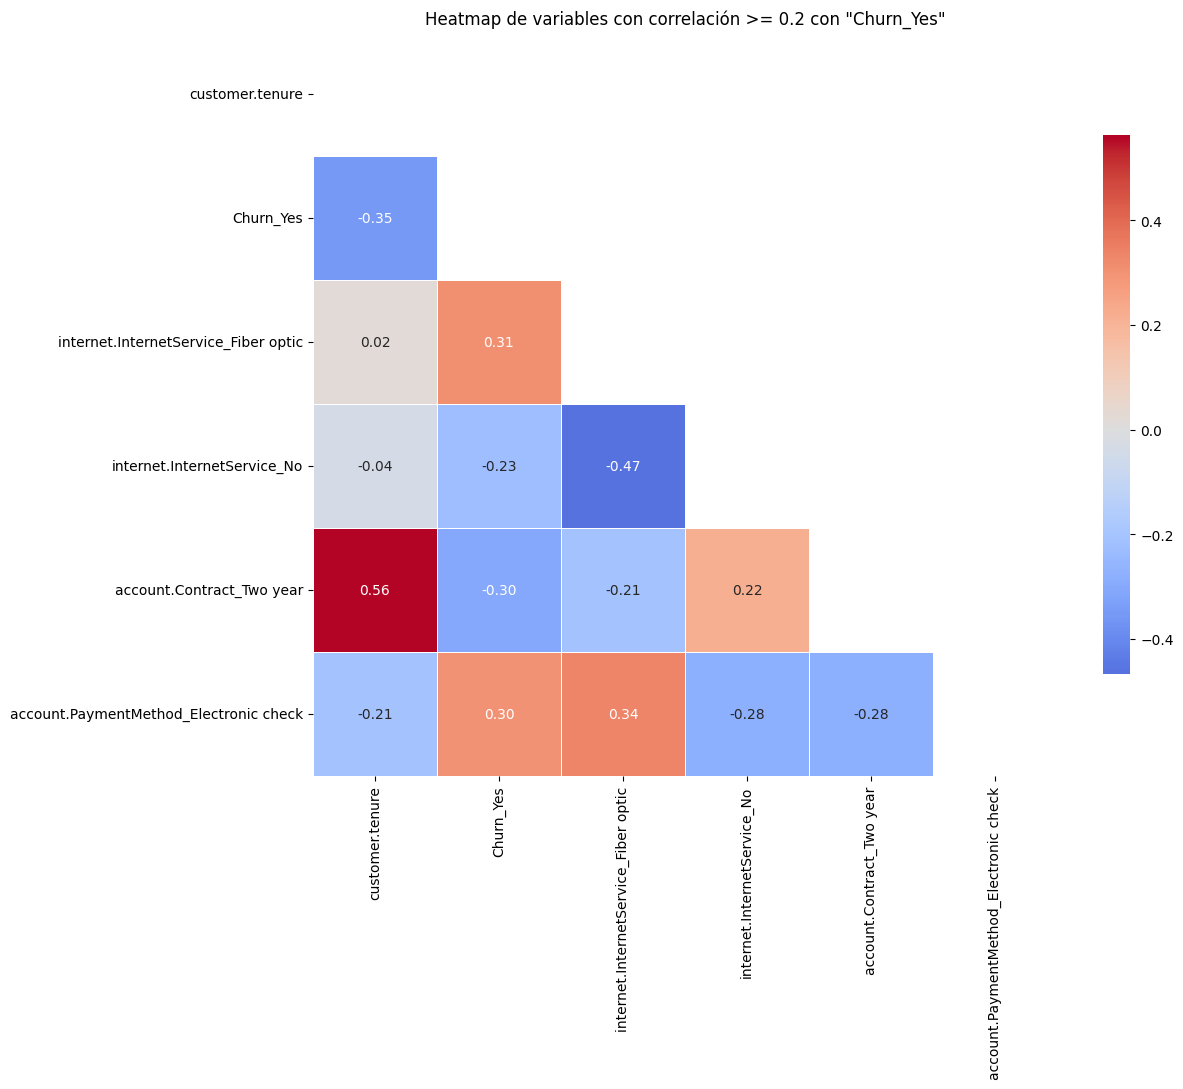

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir la variable objetivo
target_var = 'Churn_Yes'

# Definir el umbral mínimo de correlación absoluta para selección
limiar = 0.2

# Filtrar variables que tengan correlación absoluta >= umbral con la variable objetivo
# Esto crea una lista con las variables relevantes
variaveis_relevantes = corr.index[abs(corr[target_var]) >= limiar].tolist()

# Asegurar que la variable objetivo esté en la lista (si no está, añadirla)
if target_var not in variaveis_relevantes:
    variaveis_relevantes.append(target_var)

# Crear una matriz de correlación solo con las variables seleccionadas
corr_filtrada = corr.loc[variaveis_relevantes, variaveis_relevantes]

# Generar una máscara para ocultar el triángulo superior de la matriz (incluida la diagonal)
mascara = np.triu(np.ones_like(corr_filtrada, dtype=bool))

# Graficar el heatmap con la máscara aplicada para mejor visualización
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_filtrada,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    mask=mascara
)
plt.title(f'Heatmap de variables con correlación >= {limiar} con "{target_var}"')
plt.show()

---

✅ ** Análisis del nuevo heatmap de correlación**
> Recordando que el gráfico muestra **correlaciones ≥ 0.2** (o ≤ -0.2) con la variable objetivo `Churn_Yes`.

---
🔍 **Correlación con `Churn_Yes` (variable objetivo)**

| Variable                                 | Correlación con Churn\_Yes | Interpretación                                                                                                               |
| ---------------------------------------- | -------------------------- | ---------------------------------------------------------------------------------------------------------------------------- |
| `internet.InternetService_Fiber optic`   | **+0.31**                  | Clientes con fibra óptica tienen **mayor probabilidad de churn**. Puede estar relacionado al costo o a la competitividad.    |
| `account.PaymentMethod_Electronic check` | **+0.30**                  | Pagos por cheque electrónico están asociados a más churn — quizás por perfil de cliente menos fidelizado.                    |
| `account.Contract_Two year`              | **-0.30**                  | Contratos de 2 años reducen el churn (clientes más comprometidos o con beneficios)                                           |
| `customer.tenure`                        | **-0.35**                  | Cuanto mayor el tiempo como cliente, menor la probabilidad de churn — esperado                                               |
| `internet.InternetService_No`            | **-0.23**                  | Quienes **no usan internet** tienden a churnar menos — posiblemente perfiles más estables (adultos mayores, menos digitales) |


# 🤖 Modelos predictivos

**Importanción de las bibliotecas**

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

**Separar features y target**

In [21]:
X = df_encoded.drop(columns=['Churn_Yes'])
y = df_encoded['Churn_Yes']

**Dividir entrenamiento y prueba**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

**Normalizar**

* Vamos a entrenar Regresión Logística, que se beneficia de la normalización. Por eso, normalizamos los datos para este modelo.

* En cambio, Random Forest no necesita normalización — pero como estamos usando los mismos datos para ambos modelos, los normalizamos para mantener consistencia y simplicidad.

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Balancear entrenamiento con SMOTE**

Porque ya verificamos anteriormente que la proporción de churn estaba desbalanceada.

In [25]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

**Regresión Logística**

In [27]:
# Instanciar y entrenar
lr = LogisticRegression(random_state=42)
lr.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Regresión Logística")
print("Exactitud:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Regresión Logística
Exactitud: 0.7502369668246446
ROC AUC: 0.8453651312041925
Matriz de Confusión:
 [[1129  420]
 [ 107  454]]
              precision    recall  f1-score   support

       False       0.91      0.73      0.81      1549
        True       0.52      0.81      0.63       561

    accuracy                           0.75      2110
   macro avg       0.72      0.77      0.72      2110
weighted avg       0.81      0.75      0.76      2110



**Random Forest**

In [28]:
# Instanciar y entrenar
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Random Forest")
print("Exactitud:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest
Exactitud: 0.7786729857819905
ROC AUC: 0.8241531250683265
Matriz de Confusión:
 [[1307  242]
 [ 225  336]]
              precision    recall  f1-score   support

       False       0.85      0.84      0.85      1549
        True       0.58      0.60      0.59       561

    accuracy                           0.78      2110
   macro avg       0.72      0.72      0.72      2110
weighted avg       0.78      0.78      0.78      2110



# Correción de Hiperparametros

In [29]:
from sklearn.model_selection import GridSearchCV

# Define los parametros grid para la Regresión Logistica
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] # 'liblinear' supports both l1 and l2 penalties
}

# Iniciamos GridSearchCV para la Regresión Logistica
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='roc_auc')


grid_search_lr.fit(X_train_bal, y_train_bal)

# Imprime los mejores parámetros y el mejor score para la Regresión Logistica
print("Mejores parámetros para Regresión Logística:", grid_search_lr.best_params_)
print("Mejor ROC AUC para Regresión Logística:", grid_search_lr.best_score_)

# obtiene el mejor modelo
best_lr_model = grid_search_lr.best_estimator_

# Realiza las predicciones con el mejor modelo de Regresión Logistica
y_pred_lr_tuned = best_lr_model.predict(X_test_scaled)
y_prob_lr_tuned = best_lr_model.predict_proba(X_test_scaled)[:, 1]

# Evalua el mejor modelo de Regresión Logistica
print("\nRegresión Logística (Hiperparámetros Optimizados)")
print("Exactitud:", accuracy_score(y_test, y_pred_lr_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr_tuned))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_lr_tuned))
print(classification_report(y_test, y_pred_lr_tuned))

# Define los valores  grid para el  Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializa  GridSearchCV para el  Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc')


grid_search_rf.fit(X_train_bal, y_train_bal)

# Imprime los mejores parametros para el modelo Random Forest
print("\nMejores parámetros para Random Forest:", grid_search_rf.best_params_)
print("Mejor ROC AUC para Random Forest:", grid_search_rf.best_score_)

# Obtiene el mejor modelo de Random Forest
best_rf_model = grid_search_rf.best_estimator_

# Hace predicciones con el mejor modelo de Random Forest
y_pred_rf_tuned = best_rf_model.predict(X_test_scaled)
y_prob_rf_tuned = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Evalua el mejor modelo de Random Forest
print("\nRandom Forest (Hiperparámetros Optimizados)")
print("Exactitud:", accuracy_score(y_test, y_pred_rf_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf_tuned))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_rf_tuned))
print(classification_report(y_test, y_pred_rf_tuned))

Mejores parámetros para Regresión Logística: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor ROC AUC para Regresión Logística: 0.8587204100381586

Regresión Logística (Hiperparámetros Optimizados)
Exactitud: 0.7511848341232228
ROC AUC: 0.8452235874101973
Matriz de Confusión:
 [[1131  418]
 [ 107  454]]
              precision    recall  f1-score   support

       False       0.91      0.73      0.81      1549
        True       0.52      0.81      0.63       561

    accuracy                           0.75      2110
   macro avg       0.72      0.77      0.72      2110
weighted avg       0.81      0.75      0.76      2110


Mejores parámetros para Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor ROC AUC para Random Forest: 0.9303580168490244

Random Forest (Hiperparámetros Optimizados)
Exactitud: 0.7725118483412322
ROC AUC: 0.8265271482147645
Matriz de Confusión:
 [[1291  258]
 [ 222  339]]
              precision    rec

# 📄 Conclusión

Basado en el análisis exploratorio de datos y los resultados de los modelos predictivos (tanto los iniciales como los optimizados con hiperparámetros), podemos extraer las siguientes conclusiones sobre los factores que influyen en la probabilidad de que un cliente abandone la empresa (Churn):

**Factores Clave que Aumentan la Probabilidad de Churn:**

* **Servicio de Internet de Fibra Óptica (`internet.InternetService_Fiber optic`):** Existe una correlación positiva significativa entre tener servicio de fibra óptica y la probabilidad de churn. Esto sugiere que los clientes con este tipo de servicio son más propensos a irse. Esto podría deberse a varios factores, como un mayor costo del servicio, la disponibilidad de alternativas competitivas en el mercado, o posibles problemas con la calidad del servicio de fibra óptica en comparación con otras opciones.

* **Método de Pago "Cheque Electrónico" (`account.PaymentMethod_Electronic check`):** Los clientes que pagan con cheque electrónico también muestran una mayor propensión al churn. Este método de pago podría estar asociado con perfiles de clientes menos fidelizados o que prefieren métodos de pago más flexibles, lo que facilita el cambio a otro proveedor.

**Factores Clave que Reducen la Probabilidad de Churn:**

* **Antigüedad del Cliente (`customer.tenure`):** Como era de esperar, cuanto más tiempo lleva un cliente con la empresa, menor es la probabilidad de que se dé de baja. La antigüedad es un fuerte indicador de lealtad y satisfacción del cliente.

* **Contrato de Dos Años (`account.Contract_Two year`):** Los clientes con contratos de dos años tienen una probabilidad considerablemente menor de churn. Esto indica que los contratos a largo plazo son efectivos para retener clientes, probablemente debido a compromisos contractuales, descuentos o beneficios asociados a este tipo de contrato.

* **No Tener Servicio de Internet (`internet.InternetService_No`):** Curiosamente, los clientes que no tienen ningún servicio de internet con la empresa tienden a churnar menos. Esto podría sugerir que este segmento de clientes tiene necesidades más básicas de telecomunicaciones y es menos propenso a cambiar de proveedor, o que no están expuestos a las mismas ofertas competitivas que los usuarios de internet.

**Evaluación de los Modelos Predictivos:**

Se evaluaron dos modelos, Regresión Logística y Random Forest, para predecir el churn. Se realizaron pruebas iniciales y luego se optimizaron sus hiperparámetros utilizando `GridSearchCV`.

* **Regresión Logística (Inicial vs. Optimizado):**
    * **Inicial:** Exactitud: 75%, ROC AUC: 0.85, Recall (Churn): 81%, Precision (Churn): 52%.
    * **Optimizado:** Exactitud: 75%, ROC AUC: 0.85, Recall (Churn): 81%, Precision (Churn): 52%.
    * **Conclusión:** La optimización de hiperparámetros con `GridSearchCV` no produjo una mejora significativa en las métricas de rendimiento para la Regresión Logística en este caso particular, manteniendo resultados muy similares a los del modelo inicial. Los mejores parámetros encontrados fueron `{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}`.

* **Random Forest (Inicial vs. Optimizado):**
    * **Inicial:** Exactitud: 78%, ROC AUC: 0.82, Recall (Churn): 60%, Precision (Churn): 58%.
    * **Optimizado:** Exactitud: 77%, ROC AUC: 0.83, Recall (Churn): 60%, Precision (Churn): 57%.
    * **Conclusión:** La optimización de hiperparámetros para Random Forest resultó en un ligero aumento en el ROC AUC (de 0.82 a 0.83) y una pequeña disminución en la exactitud (de 78% a 77%). Las métricas de Recall y Precision para la clase Churn se mantuvieron muy similares. Aunque la mejora en el ROC AUC es marginal, indica una ligera mejora en la capacidad del modelo para distinguir entre clases positivas y negativas. Los mejores parámetros encontrados fueron `{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}`.

**Comparación General de Modelos (Optimizado):**

Considerando los modelos con hiperparámetros optimizados:

* **Regresión Logística Optimizada:** Continúa destacando por su alto recall para la clase Churn (81%), siendo más efectiva para identificar a la mayoría de los clientes que potencialmente se irán. Sin embargo, tiene una precisión más baja (52%), lo que significa que también marca a bastantes clientes que no churnearán como si lo fueran (falsos positivos).
* **Random Forest Optimizado:** Ofrece una exactitud general ligeramente mayor (77%) y un mejor equilibrio entre precisión y recall para la clase Churn (ambos alrededor del 60%). Es menos propenso a los falsos positivos que la Regresión Logística, pero pierde más casos de churn real.

**Implicaciones:**

Los hallazgos de correlación y los resultados de los modelos (tanto iniciales como optimizados) sugieren áreas clave en las que la empresa podría enfocarse para reducir el churn:

* **Clientes de Fibra Óptica:** Investigar las razones detrás del mayor churn en este segmento. Podría ser necesario revisar precios, mejorar la calidad del servicio, o ofrecer paquetes más atractivos.
* **Métodos de Pago:** Considerar incentivos o programas de fidelización para clientes que pagan con cheque electrónico para fomentar métodos de pago más estables y reducir la probabilidad de abandono.
* **Estrategias de Retención:** Continuar promoviendo los contratos a largo plazo y desarrollar estrategias específicas para retener a los clientes a medida que aumenta su antigüedad, como programas de recompensas por lealtad.

En cuanto a los modelos, la elección entre la Regresión Logística optimizada y el Random Forest optimizado dependerá de la prioridad del negocio. Si el objetivo principal es identificar la mayor cantidad posible de clientes propensos a churnar (para acciones preventivas y proactivas), la Regresión Logística sigue siendo la opción más adecuada debido a su mayor recall. Si la prioridad es una mayor exactitud general y minimizar los falsos positivos, el Random Forest podría ser preferible.

